## Principal Component Analysis (PCA) from Scratch!

Given:

    X: a numpy array of shape mxn, m being the number of rows and n being the number of features:
    Y: Y of shape mx1 (which is not needed for PCA)

In [1]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cancer = load_breast_cancer()
X_cancer = cancer['data']
y_cancer = cancer['target']

n_samples_cancer, n_features_cancer = X_cancer.shape

print('Number of samples:', n_samples_cancer)
print('Number of features:', n_features_cancer)

Number of samples: 569
Number of features: 30


Step 1: Calculate the mean vector:
$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i , dim = 1 \times n
$$

In [2]:
m, n = X_cancer.shape # 1x1
mu = np.mean(X_cancer, axis=0) # n, 
std = np.std(X_cancer, axis=0) # n,
X_cancer_normalized = ( X_cancer - mu ) / std

Step 2: Subtract the mean vector from X:
$$
X_c = X - \mu , dim = m \times n
$$

In [3]:
X_c = X_cancer_normalized # mxn, autocasting

Step 3: Calcualte the covariance matrix:
$$
\Sigma = \frac{1}{m} X_c^T . X_c , dim = n \times n 
$$

In [4]:
sigma = X_c.T @ X_c / m # nxn
# or: sigma = np.dot(X_c.T, X_c) / m

Step 4: Calculate the eigenvalues and eigenvectors of the covariance matrix:
$$
\text{det}(A - \lambda I) = 0, (A - \lambda_i I)v_i = 0
$$

In [5]:
lambdas, V = np.linalg.eigh(sigma) # n, and n x n
lambdas.shape, V.shape

((30,), (30, 30))

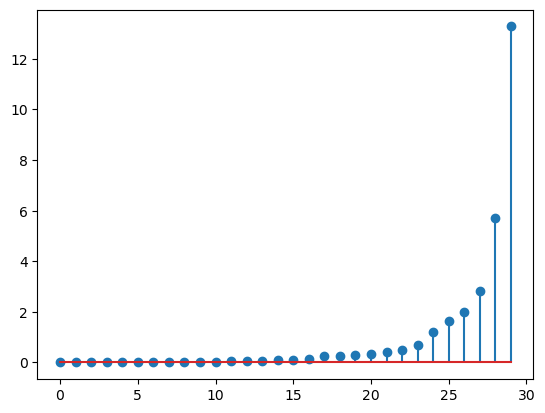

In [6]:
plt.stem(range(0, 30), lambdas)
plt.show()

In [7]:
lambdas

array([1.33044823e-04, 7.48803097e-04, 1.58933787e-03, 6.90046388e-03,
       8.17763986e-03, 1.54812714e-02, 1.80550070e-02, 2.43408378e-02,
       2.74394025e-02, 2.99728939e-02, 3.11594025e-02, 4.94775918e-02,
       5.26187835e-02, 5.93990378e-02, 7.98628010e-02, 9.41349650e-02,
       1.57009724e-01, 2.41357496e-01, 2.61161370e-01, 2.93915696e-01,
       3.50693457e-01, 4.16894812e-01, 4.76617140e-01, 6.75220114e-01,
       1.20735661e+00, 1.64873055e+00, 1.98064047e+00, 2.81794898e+00,
       5.69135461e+00, 1.32816077e+01])

Step 5: Sort the eigenvectors according to their corresponding eigenvalues in descending order:
$$
\lambda, dim = n \times n
$$

$$
V, dim = n \times n
$$

In [8]:
sorted_indexes = np.argsort(-abs(lambdas)) # eigenvalues could be negative?
lambdas = lambdas[sorted_indexes]
V = V[sorted_indexes][::-1]
lambdas

array([1.32816077e+01, 5.69135461e+00, 2.81794898e+00, 1.98064047e+00,
       1.64873055e+00, 1.20735661e+00, 6.75220114e-01, 4.76617140e-01,
       4.16894812e-01, 3.50693457e-01, 2.93915696e-01, 2.61161370e-01,
       2.41357496e-01, 1.57009724e-01, 9.41349650e-02, 7.98628010e-02,
       5.93990378e-02, 5.26187835e-02, 4.94775918e-02, 3.11594025e-02,
       2.99728939e-02, 2.74394025e-02, 2.43408378e-02, 1.80550070e-02,
       1.54812714e-02, 8.17763986e-03, 6.90046388e-03, 1.58933787e-03,
       7.48803097e-04, 1.33044823e-04])

Fun: Contribution of topN sorted!

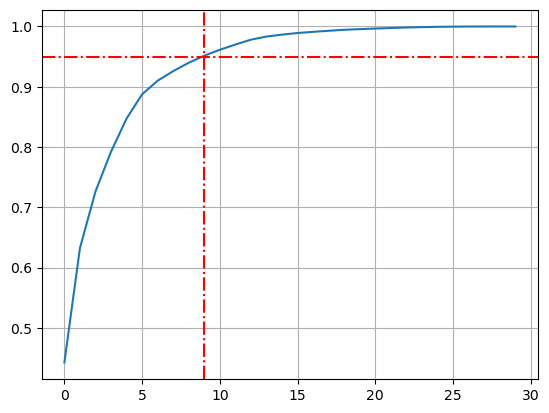

In [9]:
lambdas_scaled = lambdas / np.sum(lambdas)
plt.plot(range(0,len(lambdas)), np.cumsum(lambdas_scaled))
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='-.')
plt.axvline(x=9, color='r', linestyle='-.')
plt.show()

Step 6: Select the top k eigenvectors (principal components)
$$
W = top_k(V), dim = n \times k
$$

In [10]:
k = 5
W = V[:, -k:] # n x k

Step 7: Transform the data, X, into the new subspace:
$$
X_T = X_C \times W, dim = m \times k
$$

In [11]:
X_T = X_c @ W # m * k
X_T.shape

(569, 5)

Step 8: Done!

In [12]:
pd.DataFrame(X_T).corr().style.background_gradient(cmap="coolwarm")

,0,1,2,3,4
0,1.000000,-0.000000,0.000000,0.000000,-0.000000
1,-0.000000,1.000000,0.000000,-0.000000,0.000000
2,0.000000,0.000000,1.000000,-0.000000,-0.000000
3,0.000000,-0.000000,-0.000000,1.000000,-0.000000
4,-0.000000,0.000000,-0.000000,-0.000000,1.000000


# Proper PCA Class

In [13]:
import numpy as np

class PCATransformer:
    def __init__(self, explained_variance_ratio=None, n_components=None):
        """
        Initializes the PCATransformer class.
        
        Args:
          explained_variance_ratio (float, optional): The desired explained variance ratio. Defaults to 0.95.
          n_components (int, optional): The desired number of principal components to retain. Defaults to None.
        
        Raises:
          ValueError: If both explained_variance_ratio and n_components are provided.
        """
        self.explained_variance_ratio = explained_variance_ratio
        self.n_components = n_components
        
        if explained_variance_ratio is not None and n_components is not None:
            raise ValueError("Only one of explained_variance_ratio or n_components can be specified.")
        
        self.mean_ = None
        self.std_ = None
        self.covariance_matrix_ = None
        self.eigenvalues_ = None
        self.eigenvectors_ = None
        self.principal_components_ = None

    def _validate_input(self, X):
        """
        Validates the input data X.

        Args:
            X (np.ndarray): The input data.

        Raises:
            ValueError: If the input data is not a 2D NumPy array or contains NaN or infinite values.
        """
        if not isinstance(X, np.ndarray) or X.ndim != 2:
            raise ValueError("Input data must be a 2D NumPy array.")

        if np.isnan(X).any() or np.isinf(X).any():
            raise ValueError("Input data contains NaN or infinite values.")

    def _center_and_scale(self, X):
        """
        Centers and scales the input data.

        Args:
            X (np.ndarray): The input data of shape (n_samples, n_features).

        Returns:
            np.ndarray: The centered and scaled data.
        """
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)

        # Handle features with zero variance
        self.std_[self.std_ == 0] = 1e-6

        X_centered = (X - self.mean_) / self.std_
        return X_centered

    def _compute_covariance_matrix(self, X):
        """
        Computes the covariance matrix of the input data.

        Args:
            X (np.ndarray): The input data of shape (n_samples, n_features).

        Returns:
            np.ndarray: The covariance matrix of shape (n_features, n_features).
        """
        n_samples, n_features = X.shape
        X_centered = self._center_and_scale(X)
        self.covariance_matrix_ = X_centered.T @ X_centered / n_samples
        return self.covariance_matrix_

    def _compute_eigen(self):
        """
        Computes the eigenvalues and eigenvectors of the covariance matrix.
        """
        self.eigenvalues_, self.eigenvectors_ = np.linalg.eigh(self.covariance_matrix_)

        # Sort the eigenvectors in descending order of eigenvalues
        sorted_indices = np.argsort(-abs(self.eigenvalues_))
        self.eigenvalues_ = self.eigenvalues_[sorted_indices]
        self.eigenvectors_ = self.eigenvectors_[:, sorted_indices]

    def _determine_k(self):
        """
        Determines the number of principal components to retain based on the explained variance ratio.
        """
        total_variance = np.sum(self.eigenvalues_)
        explained_variance_ratio = np.cumsum(self.eigenvalues_) / total_variance
        self.n_components = np.argmax(explained_variance_ratio >= self.explained_variance_ratio) + 1

    def fit(self, X):
        """
        Fits the PCA transformer to the input data X.

        Args:
            X (np.ndarray): The input data of shape (n_samples, n_features).

        Returns:
            self: The fitted PCATransformer instance.
        """
        self._validate_input(X)
        self._compute_covariance_matrix(X)
        self._compute_eigen()
        
        if self.n_components is None:
            self._determine_k()


        # Get the top K principal components
        self.principal_components_ = self.eigenvectors_[:, :self.n_components]

        return self

    def transform(self, X):
        """
        Applies the PCA transformation to the input data X.

        Args:
            X (np.ndarray): The input data of shape (n_samples, n_features).

        Returns:
            np.ndarray: The transformed data of shape (n_samples, k).
        """
        self._validate_input(X)

        if self.mean_ is None or self.std_ is None or self.principal_components_ is None:
            raise ValueError("PCATransformer must be fitted before transforming data.")

        # Center and scale the data
        X_centered = np.subtract(X, self.mean_)
        X_normalized = np.divide(X, self.std_)

        # Project the data onto the principal component space
        X_transformed = X_centered @ self.principal_components_
        return X_transformed

In [14]:
customPCA = PCATransformer(n_components=8)
customPCA.fit(X_cancer_normalized)
X_transformed = customPCA.transform(X_cancer_normalized)

## Final data visualization to top it off

In [15]:
df = pd.DataFrame(X_cancer)
df.corr().style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
1,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
2,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
3,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
4,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
5,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
6,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
7,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
8,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
9,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


In [16]:
X_transformed.shape

(569, 8)

In [17]:
df = pd.DataFrame(X_transformed)
df.corr().style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6,7
0,1.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
1,0.000000,1.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2,0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
3,0.000000,-0.000000,-0.000000,1.000000,0.000000,-0.000000,-0.000000,0.000000
4,-0.000000,-0.000000,-0.000000,0.000000,1.000000,-0.000000,0.000000,0.000000
5,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000
6,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,1.000000,-0.000000
7,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,1.000000


## Other data

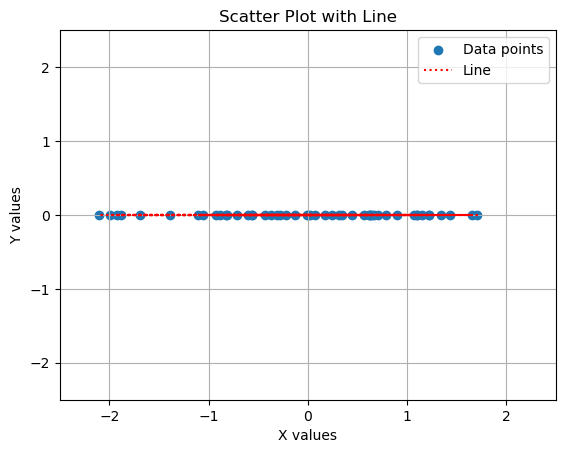

In [18]:
y = np.random.randn(50, 1)
y_norm = (y - y.mean()) / y.std()
x = np.zeros_like(y_norm)
random_data = np.hstack((y_norm, x))

scatter = plt.scatter(random_data[:, 0], random_data[:, 1], label='Data points')
line, = plt.plot(random_data[:, 0], random_data[:, 1], 'r:', label='Line')

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plt.title('Scatter Plot with Line')
plt.xlabel('X values')
plt.ylabel('Y values')

plt.legend(handles=[scatter, line])

plt.grid()
plt.show()

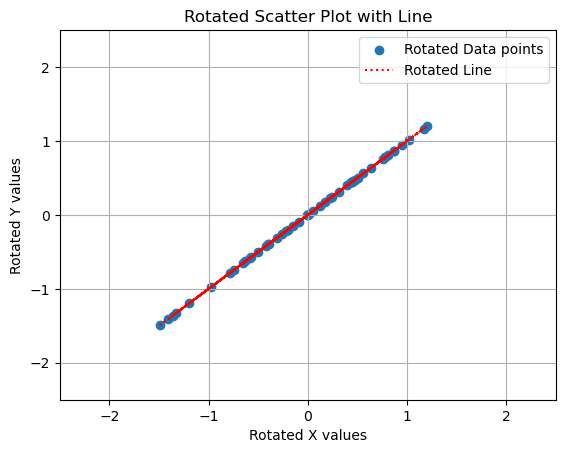

In [19]:
theta = 45
c, s = np.cos(np.pi*theta/180), np.sin(np.pi*theta/180)
rot_kernel = np.array([
    [c, -s],
    [s, c]
])
rotated_random_data = random_data @ rot_kernel.T

scatter = plt.scatter(rotated_random_data[:, 0], rotated_random_data[:, 1], label='Rotated Data points')
line, = plt.plot(rotated_random_data[:, 0], rotated_random_data[:, 1], 'r:', label='Rotated Line')

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plt.title('Rotated Scatter Plot with Line')
plt.xlabel('Rotated X values')
plt.ylabel('Rotated Y values')


plt.legend(handles=[scatter, line])
plt.grid()
plt.show()

In [20]:
customPCA2 = PCATransformer(n_components=2)
customPCA2.fit(rotated_random_data)
rotated_random_data_transformed = customPCA2.transform(rotated_random_data)

### Computing the mean and variance of the data before and after PCA and plotting them

In [21]:
y_norm.mean(), y_norm.std()

(-1.9984014443252817e-17, 0.9999999999999999)

In [22]:
rotated_random_data_transformed.mean(), rotated_random_data_transformed.std()

(-2.4424906541753444e-17, 0.7071067811865475)

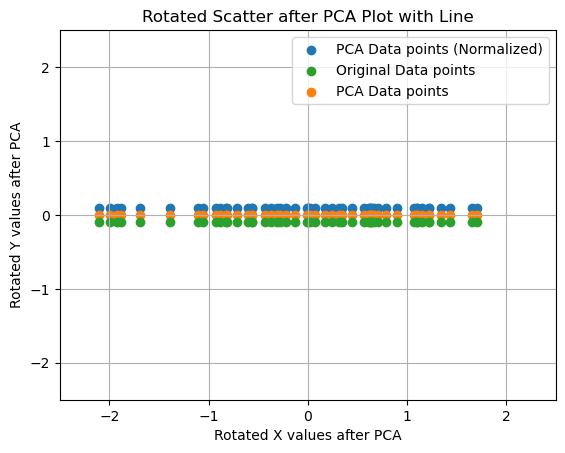

In [23]:
scatter = plt.scatter(
    (rotated_random_data_transformed[:, 0] - rotated_random_data_transformed[:, 0].mean()) / rotated_random_data_transformed[:, 0].std(),
    rotated_random_data_transformed[:, 1] + 0.1,
    label='PCA Data points (Normalized)'
)

scatter3 = plt.scatter(
    rotated_random_data_transformed[:, 0],
    rotated_random_data_transformed[:, 1],
    label='PCA Data points'
)

scatter2 = plt.scatter(
    y_norm,
    np.zeros_like(y) - 0.1,
    label='Original Data points'
)

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plt.title('Rotated Scatter after PCA Plot with Line')
plt.xlabel('Rotated X values after PCA')
plt.ylabel('Rotated Y values after PCA')


plt.legend(handles=[scatter, scatter2, scatter3])
plt.grid()
plt.show()

In [24]:
customPCA2.eigenvalues_, customPCA2.eigenvectors_

(array([2., 0.]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

### Let's add a very small amount of noise to it

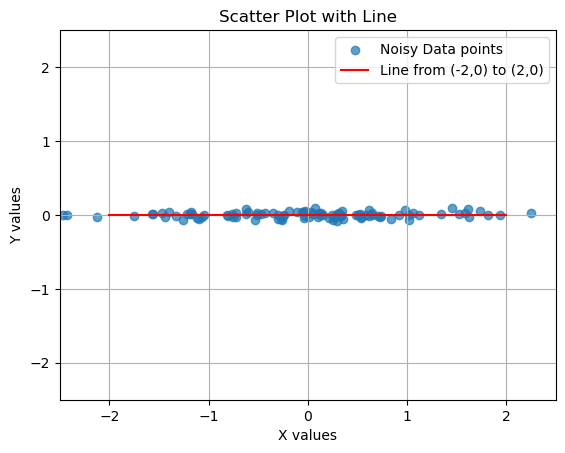

In [25]:
y = np.random.randn(100, 1)
y = (y - y.mean()) / y.std()
x = np.zeros_like(y)
x_copy = x
n = np.random.randn(100, 1) * 0.04
x += n
random_data_noisy = np.hstack((y, x))

scatter = plt.scatter(random_data_noisy[:, 0], random_data_noisy[:, 1], label='Noisy Data points', alpha=0.7)

# Add a line between (-2, 0) and (2, 0)
plt.plot([-2, 2], [0, 0], 'r-', label='Line from (-2,0) to (2,0)')

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plt.title('Scatter Plot with Line')
plt.xlabel('X values')
plt.ylabel('Y values')

plt.legend()

plt.grid()
plt.show()

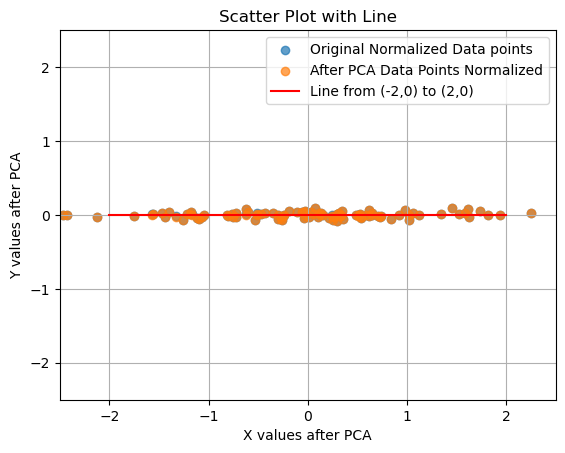

In [26]:
rotated_random_data_noisy = random_data_noisy @ rot_kernel.T

customPCA3 = PCATransformer(n_components=2)
customPCA3.fit(rotated_random_data_noisy)
PCA_random_data_noisy = customPCA3.transform(rotated_random_data_noisy)


scatter_0 = plt.scatter(
    ( random_data_noisy[:, 0] - random_data_noisy[:, 0].mean() ) / random_data_noisy[:, 0].std(),
    random_data_noisy[:, 1],
    label='Original Normalized Data points',
    alpha=0.7
)


scatter = plt.scatter(
    (PCA_random_data_noisy[:, 0] - PCA_random_data_noisy[:, 0].mean()) / PCA_random_data_noisy[:, 0].std(),
    PCA_random_data_noisy[:, 1],
    label='After PCA Data Points Normalized',
    alpha=0.7
)

# Add a line between (-2, 0) and (2, 0)
plt.plot([-2, 2], [0, 0], 'r-', label='Line from (-2,0) to (2,0)')
# plt.plot([1.5, -1.5], [1.5, -1.5], 'r-', label='Line from (-1.5,-1.5) to (1.5,1.5)')

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

plt.title('Scatter Plot with Line')
plt.xlabel('X values after PCA')
plt.ylabel('Y values after PCA')

plt.legend()

plt.grid()
plt.show()

In [27]:
customPCA3.eigenvalues_, customPCA3.eigenvectors_

(array([1.99751552, 0.00248448]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

In [28]:
customPCA3.mean_, customPCA3.std_

(array([-0.00047125,  0.00047125]), array([0.7037252 , 0.71136756]))

This just shows that the points are kind of overlapping which has a LOT to do with the normalization